# Development of code for `yelpaffluence_nyc.py` class

### Britt Allen, Bernard Kurka, Tom Ludlow 1/14/19

In [1082]:
import os
os.environ["PROJ_LIB"] = "/anaconda3/share/proj/"; # Location of 'epsg' in directories

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from yelpapi import YelpAPI

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score

class YelpAffluence_NYC:
    """
    Class created January 2019 by Britt Allen, Bernard Kurka, Tom Ludlow in 
    General Assembly's Data Science Immersive as part of Project 4.  
    
    Object and methods allow user to identify a custom "affluence" metric on 
    a scale of $ to $$$$, similar to that used by Yelp for an establishment's 
    price rating.
    
    Methods fit a classification model of Yelp pricing data for New York City
    in January 2019.  **NOTE: Source data must be present in directory to function 
    properly.**  User may enter a string containing a ZIP code or neighborhood
    name, and the model will assign it an affluence rating relative to other
    neighborhoods/ZIPs in NYC.
    """
    
    def __init__(self, api_key=None):
        """
        Instantiate object with valid API key to access Yelp Fusion API.
        
        api_key: string
        """        
        # Instantiate variables
        self.api_key = api_key
        self.data = pd.read_csv('../Data/nyc_best.csv')
        
        self.prices = ['$','$\$','$\$\$','$\$\$\$']
        self.colors = ['tomato','goldenrod','seagreen','royalblue']
        self.cluster_num_dict = {0:0,1:3,2:1,3:2}
        self.cluster_dict = {0:'$',1:'$\$\$\$',2:'$\$',3:'$\$\$'}
        self.searched=False
        
        # Instantiate models
        self.features = ['pr_1s','pr_2s','pr_3s','pr_4s','pr_totms']
        self.kmeans = KMeans(n_clusters=4, init='random', algorithm='full', random_state=42, tol=0.0001)
        self.knn = KNeighborsClassifier(n_neighbors=15)
        self.ss = StandardScaler()
        self.result = pd.DataFrame(columns=['pred'])
        
    def query_to_df(self, loc_in, cat_in=['none'], 
                    sort_in='distance', limit_in=50, 
                    cols=['categories','alias','city','state','zip_code','price','review_count','latitude','longitude']):
        """Available arguments:
        loc_in (str): location (zip, city, neighborhood, etc.)
        cat_in (list): categories - default is ['restaurants','shopping','localservices']
        sort_in (str): sort criterion of 'distance','best_match','review_count' - default is 'distance'
        limit_in (int): number of results to pull per category, max is 50 - default is 50
        cols (list): columns for dataframe, matching API results key names - default is
        ['categories','alias','city','state','zip_code','price','review_count','latitude','longitude']
        """
        # Set Yelp Fusion API Key and establish API connection
        if not self.api_key:
            self.api_key = '21Pt2l8__qgIdL0ZpgYC_yWblJ_O8_vJ3_-tIybHDyuQl9oVBXAzAXQWqMmIrz7idLyc7owv4-lfSON0QjKJN4pvQei4rUQAGSZcGcVTQc4HtBseUcztUPkVrAItXHYx'
        api_obj = YelpAPI(self.api_key, timeout_s=3.0)

        # Instantiate empty DataFrame with desired output columns
        output_df = pd.DataFrame(columns=['search_term']+cols)

        # Create iterable list of limit amounts <= 50 so that full limit argument is covered
        # ex. 70 -> [50,20]
        limit_list = []
        if limit_in > 50:
            req = limit_in  # req starts at limit argument and counts down by 50 until < 50
            while req > 50:
                limit_list.append(50)
                req -= 50
            limit_list.append(req)
        else:
            limit_list.append(limit_in) # if req < 50 append remaining amount to list

        # Loop through category argument list items
        for cat in cat_in:
            cat_df = pd.DataFrame(columns=['search_term']+cols) # Create empty DataFrame with addl col for category
            for j, limit in enumerate(limit_list): # Perform API pulls with all limits in limit_list

                # API call saved to json dict
                if cat=='none':
                    response = api_obj.search_query(location=loc_in, sort_by=sort_in, limit=limit, offset=(j*50))
                else:
                    response = api_obj.search_query(location=loc_in, categories=[cat], sort_by=sort_in, limit=limit, offset=(j*50))
                response_df = pd.DataFrame(response['businesses']) # Save business data to DataFrame

                # Create iteration DataFrame to process each API response (up to 50 results)
                iter_df = pd.DataFrame(columns=['search_term']+cols)
                iter_df['search_term'] = [cat for i in range(len(response_df))] # Add category value for each row

                # Iterate through each requested column argument and format for storage in output DataFrame
                for col_name in cols:
                    # Convert list of categories into single comma-separated string
                    if col_name == 'categories':
                        # Exception handling: not all responses include all categories
                        try:
                            for k, cell in enumerate(response_df['categories']):
                                iter_cat_str = ''
                                for d in cell:
                                    iter_cat_str += str(d['alias']+', ')
                                iter_df.loc[k, 'categories'] = iter_cat_str[:-2] # Save final string, without final ', ' 
                        except:
                            pass
                    elif col_name in ('city','state','zip_code'): # Access location data through 'location' key value
                        try:
                            iter_df[col_name] = [response_df['location'][i][col_name] for i in range(response_df.shape[0])]
                        except:
                            pass
                    elif col_name in ('latitude','longitude'): # Access latitude/longitude through 'coordinates' key value
                        try:
                            iter_df[col_name] = [response_df['coordinates'][i][col_name] for i in range(response_df.shape[0])]
                        except:
                            pass
                    else:
                        try:
                            iter_df[col_name] = response_df[col_name] # Anything else access directly
                        except:
                            pass
                cat_df = cat_df.append(iter_df)
            output_df = output_df.append(cat_df)
        output_df.index = range(output_df.shape[0])
        return output_df
    
    def api_pull(self, zip_list, cats=[None], sort='best_match', limit=50):
        column_list = ['zip','city','state','cat',
                       'pr_1','rv_1','pr_2','rv_2',
                       'pr_3','rv_3','pr_4','rv_4',
                       'avg_lat','avg_long']

        api_data = pd.DataFrame(columns=column_list)
        for z in zip_list:
            print(z)
            df = self.query_to_df(z, cats, limit_in=limit, sort_in=sort)

            loop_df = pd.Series(index=column_list)

            loop_df['zip'] = z
            try:
                loop_df['city'] = df.city.value_counts(ascending=False).index[0]
                loop_df['state'] = df.state.value_counts(ascending=False).index[0]
            except: 
                pass
            
            loop_df['cat'] = 'None'

            loop_df['pr_1'] = df[df.price=='$'].shape[0]
            loop_df['rv_1'] = df[df.price=='$'].review_count.sum()
            loop_df['pr_2'] = df[df.price=='$$'].shape[0]
            loop_df['rv_2'] = df[df.price=='$$'].review_count.sum()
            loop_df['pr_3'] = df[df.price=='$$$'].shape[0]
            loop_df['rv_3'] = df[df.price=='$$$'].review_count.sum()
            loop_df['pr_4'] = df[df.price=='$$$$'].shape[0]
            loop_df['rv_4'] = df[df.price=='$$$$'].review_count.sum()

            loop_df['avg_lat'] = df.latitude.mean()
            loop_df['avg_long'] = df.longitude.mean()

            api_data = api_data.append(loop_df, ignore_index=True)

        api_data.zip = api_data.zip.astype(str)

        return api_data
    
    def fit_model(self):
        """
        Create sklearn ensemble models and fit based on yelp_nyc_total.csv data
        """ 
        self.data['pr_2m'] = self.data['pr_2'] * 2
        self.data['pr_3m'] = self.data['pr_3'] * 3
        self.data['pr_4m'] = self.data['pr_4'] * 4
        self.data['pr_totm'] = self.data['pr_1'] + self.data['pr_2m'] + self.data['pr_3m'] + self.data['pr_4m']
        
        ss_feat = ['pr_1','pr_2','pr_3','pr_4','pr_totm']
        data_ss = self.ss.fit_transform(self.data[ss_feat])
        
        self.data['pr_1s'] = [data_ss[i][0] for i in range(len(data_ss))]
        self.data['pr_2s'] = [data_ss[i][1] for i in range(len(data_ss))]
        self.data['pr_3s'] = [data_ss[i][2] for i in range(len(data_ss))]
        self.data['pr_4s'] = [data_ss[i][3] for i in range(len(data_ss))]
        self.data['pr_totms'] = [data_ss[i][4] for i in range(len(data_ss))]
        
        # self.data[ss_feat] = data_ss
        
        self.kmeans.fit(self.data[self.features])
        self.data['pred'] = self.kmeans.labels_
        self.data['pred_$'] = self.data.pred.map(lambda x: self.cluster_dict[x])
        self.data['pred_num'] = self.data.pred.map(lambda x: self.cluster_num_dict[x])
        self.knn.fit(self.data[self.features], self.data.pred)
        
    def get_affluence(self, locations):
        """
        Return price rating ($, $$, $$$, $$$$) for a NYC ZIP or 
        neighborhood search term
        
        location: string, list of strings
        """
        self.result = self.api_pull(locations, sort='best_match', limit=100)
        
        self.result['pr_2m'] = self.result['pr_2'] * 2
        self.result['pr_3m'] = self.result['pr_3'] * 3
        self.result['pr_4m'] = self.result['pr_4'] * 4
        self.result['pr_totm'] = self.result['pr_1'] + self.result['pr_2m'] + self.result['pr_3m'] + self.result['pr_4m']
        
        ss_feat = ['pr_1','pr_2','pr_3','pr_4','pr_totm']
        result_ss = self.ss.transform(self.result[ss_feat])
        
        self.result['pr_1s'] = [result_ss[i][0] for i in range(len(result_ss))]
        self.result['pr_2s'] = [result_ss[i][1] for i in range(len(result_ss))]
        self.result['pr_3s'] = [result_ss[i][2] for i in range(len(result_ss))]
        self.result['pr_4s'] = [result_ss[i][3] for i in range(len(result_ss))]
        self.result['pr_totms'] = [result_ss[i][4] for i in range(len(result_ss))]
            
        # self.result[self.features] = result_ss
        
        self.result['pred'] = self.knn.predict(self.result[self.features])
        self.result['pred_$'] = self.result.pred.map(lambda x: self.cluster_dict[x])
        self.result['pred_num'] = self.result.pred.map(lambda x: self.cluster_num_dict[x])
        
        self.result.zip = self.result.zip.str.split('.', expand=True)[0]
        self.result.drop(['cat'], axis=1, inplace=True)
        self.result = self.result.rename(columns={'zip':'location'})
        
        self.result = self.result.sort_values('pred_$')
        self.result.index = range(self.result.shape[0])
        
        self.searched=True
        
        return self.result
        
    def plot_query_results_mean(self):
        if not self.searched:
            return 'No stored results.'
        result_prices = self.result.pred_num.unique()
        n_tall = 2
        if len(result_prices)<3:
            n_tall = 1
        hide_last = False
        if len(result_prices) % 2:
            hide_last = True
        fig, ax = plt.subplots(n_tall,2,figsize=(12,6*n_tall), sharey=True)
        ax = ax.ravel()

        for i, n in enumerate(result_prices):
            ax[i].bar(['$','$\$','$\$\$','$\$\$\$'],
                  [self.result[self.result.pred_num==n].pr_1.mean(),self.result[self.result.pred_num==n].pr_2.mean(),
                   self.result[self.result.pred_num==n].pr_3.mean(),self.result[self.result.pred_num==n].pr_4.mean()],
                  label='Results', color=self.colors[n])
            ax[i].set_title('\$'*(n+1), fontsize=18)
            ax[i].set_xlabel('Yelp Price Ratings', fontsize=14)
            ax[i].set_ylabel('Mean Number of Businesses', fontsize=14)
            ax[i].grid()
            if hide_last:
                ax[len(result_prices)].set_visible(False)
        fig.suptitle('Mean Results for Queried Locations', fontsize=22)
        #plt.show();
        
    def plot_query_results(self):
        if not self.searched:
            return 'No stored results.'
        n_results = self.result.shape[0]
        n_tall = int(n_results / 2)
        hide_last = False
        if n_results % 2: 
            n_tall += 1
            hide_last = True
        fig, ax = plt.subplots(n_tall,2,figsize=(12,n_tall*6), sharey=True)
        ax = ax.ravel()

        for i in range(n_results):
            ax[i].bar(['$','$\$','$\$\$','$\$\$\$'],
                  [self.result.loc[i, 'pr_1'],self.result.loc[i, 'pr_2'],
                   self.result.loc[i, 'pr_3'],self.result.loc[i, 'pr_4']],
                  label=self.result.loc[i,'location'], color=self.colors[self.cluster_num_dict[self.result.loc[i,'pred']]])
            ax[i].set_title(self.result.loc[i, 'location'].title()+': '+self.result.loc[i,'pred_$'], fontsize=16)
            ax[i].set_xlabel('Yelp Price Ratings', fontsize=12)
            ax[i].set_ylabel('Number of Businesses in Location', fontsize=12)
            ax[i].grid()
            
        if hide_last:
            ax[n_results].set_visible(False)
            
        fig.suptitle('Individual Query Results', fontsize=22)
        #plt.show();
    
    def plot_model_results(self):
        """
        Display Matplotlib Pyplot results for neighborhood metrics
        """
        fig, ax = plt.subplots(2,2,figsize=(12,12), sharey=True)
        ax = ax.ravel()

        for i in range(4):
            ax[i].bar(['$','$\$','$\$\$','$\$\$\$'],
                  [self.data[self.data.pred_num==i].pr_1.mean(),self.data[self.data.pred_num==i].pr_2.mean(),
                   self.data[self.data.pred_num==i].pr_3.mean(),self.data[self.data.pred_num==i].pr_4.mean()],
                  label=self.prices[i], color=self.colors[i])
            ax[i].set_title('\$'*(i+1), fontsize=18)
            ax[i].set_xlabel('Yelp Price Ratings', fontsize=14)
            ax[i].set_ylabel('Mean Number of Businesses', fontsize=14)
            ax[i].grid()
        
        fig.suptitle('Mean Results for All NYC ZIPs', fontsize=22)
        #plt.show();
        
    def plot_nyc_map(self, x_in=16, y_in=16):
        """
        Display Matplotlib Pyplot results using latitude/longitude
        """
        plt.figure(figsize=(x_in,y_in))
        plt.clf()
        m = Basemap(projection='cyl', llcrnrlat=40.5, urcrnrlat=40.92, 
                    llcrnrlon=-74.3, urcrnrlon=-73.7, resolution='h')
        m.fillcontinents(color="#eeeeee", alpha=0.2)
        m.drawcoastlines()
        m.drawmapboundary()

        for i in range(4):
            plt.scatter(self.data[self.data.pred_num==i].avg_long, 
                        self.data[self.data.pred_num==i].avg_lat, 
                        label=self.prices[i], color=self.colors[i], alpha=0.8, s=20)
        adj_lat = 0
        self.result['loc_len'] = [len(self.result.location[i]) for i in range(len(self.result))]
        len_sort = self.result.sort_values('loc_len', ascending=False)
        
        len_sort.index = range(len(len_sort))
        for j in range(len_sort.shape[0]):
            try:
                plt.scatter(len_sort.loc[j,'avg_long'], len_sort.loc[j,'avg_lat'], 
                            marker='d', label=None, 
                            color=self.colors[self.cluster_num_dict[len_sort.loc[j,'pred']]], s=200)
                plt.annotate(len_sort.loc[j,'location'].title(), 
                             xy=(len_sort.loc[j,'avg_long'],len_sort.loc[j,'avg_lat']),
                             xytext=(-74.28,40.85-adj_lat),
                             fontsize=16, color=self.colors[self.cluster_num_dict[len_sort.loc[j,'pred']]],
                             arrowprops={'arrowstyle':'-', 
                                         'color':self.colors[self.cluster_num_dict[len_sort.loc[j,'pred']]]})
                adj_lat += 0.02
            except: pass

        plt.title('NYC by Yelp ZIP Code', fontsize=22)
        plt.xlabel('Longitude', fontsize=14)
        plt.xticks(np.arange(-74.3,-73.65,.1))
        plt.ylabel('Latitude', fontsize=14)
        plt.yticks(np.arange(40.5,40.95,.05))
        plt.legend(loc=2, fontsize='xx-large')
        #plt.show();
        
    def filter_zips(self, pr_val):
        return self.data[self.data.pred_num==pr_val]

In [1083]:
api_key = '21Pt2l8__qgIdL0ZpgYC_yWblJ_O8_vJ3_-tIybHDyuQl9oVBXAzAXQWqMmIrz7idLyc7owv4-lfSON0QjKJN4pvQei4rUQAGSZcGcVTQc4HtBseUcztUPkVrAItXHYx'

yan = YelpAffluence_NYC(api_key)


In [1097]:
yan.filter_zips(0)

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,...,pr_4m,pr_totm,pr_1s,pr_2s,pr_3s,pr_4s,pr_totms,pred,pred_$,pred_num
38,10041,New York,NY,NaN,11,1125,25,7454,1,254,...,0,64,-0.951856,-0.888591,-0.670745,-0.608939,-1.170320,0,$,0
39,10043,New York,NY,NaN,8,251,6,730,1,74,...,0,23,-1.188755,-1.701747,-0.670745,-0.608939,-1.828303,0,$,0
41,10045,New York,NY,NaN,30,2306,15,2403,2,596,...,0,66,0.548503,-1.316568,-0.513521,-0.608939,-1.138223,0,$,0
43,10055,New York,NY,NaN,10,676,14,724,14,3132,...,12,92,-1.030822,-1.359366,1.373161,0.507226,-0.720965,0,$,0
47,10081,New York,NY,NaN,25,2113,17,2518,2,23,...,4,69,0.153672,-1.230973,-0.513521,-0.236884,-1.090078,0,$,0
49,10087,New York,NY,NaN,15,511,15,1921,0,0,...,0,45,-0.635991,-1.316568,-0.827968,-0.608939,-1.475239,0,$,0
50,10095,New York,NY,NaN,15,511,15,1921,0,0,...,0,45,-0.635991,-1.316568,-0.827968,-0.608939,-1.475239,0,$,0
56,10105,New York,NY,NaN,5,676,19,6529,8,2720,...,12,79,-1.425654,-1.145377,0.429820,0.507226,-0.929594,0,$,0
57,10106,New York,NY,NaN,9,1437,19,3805,8,2620,...,4,75,-1.109789,-1.145377,0.429820,-0.236884,-0.993788,0,$,0
61,10110,New York,NY,NaN,10,637,10,774,5,1703,...,8,53,-1.030822,-1.530556,-0.041851,0.135171,-1.346852,0,$,0


In [1098]:
yan.filter_zips(1)

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,...,pr_4m,pr_totm,pr_1s,pr_2s,pr_3s,pr_4s,pr_totms,pred,pred_$,pred_num
26,10029,New York,NY,NaN,36,3786,55,11893,4,1465,...,4,162,1.022301,0.395340,-0.199074,-0.236884,0.402422,2,$\$,1
28,10031,New York,NY,NaN,39,3189,53,13328,1,104,...,0,148,1.259200,0.309744,-0.670745,-0.608939,0.177745,2,$\$,1
29,10032,New York,NY,NaN,31,4230,63,15416,0,0,...,0,157,0.627469,0.737721,-0.827968,-0.608939,0.322180,2,$\$,1
30,10033,New York,NY,NaN,40,2321,52,7929,1,469,...,0,147,1.338166,0.266947,-0.670745,-0.608939,0.161696,2,$\$,1
36,10039,New York,NY,NaN,31,4250,64,18691,2,228,...,0,165,0.627469,0.780519,-0.513521,-0.608939,0.450567,2,$\$,1
37,10040,New York,NY,NaN,32,2711,60,11418,2,562,...,0,158,0.706436,0.609328,-0.513521,-0.608939,0.338228,2,$\$,1
53,10102,Corona,NY,NaN,42,10944,50,13649,2,1209,...,0,148,1.496099,0.181351,-0.513521,-0.608939,0.177745,2,$\$,1
69,10119,New York,NY,NaN,28,1589,31,3396,2,203,...,0,96,0.390571,-0.631805,-0.513521,-0.608939,-0.656771,2,$\$,1
71,10122,New York,NY,NaN,28,4106,38,6159,0,0,...,0,104,0.390571,-0.332221,-0.827968,-0.608939,-0.528384,2,$\$,1
84,10163,New York,NY,NaN,31,1814,36,5829,4,487,...,0,115,0.627469,-0.417816,-0.199074,-0.608939,-0.351852,2,$\$,1


In [1099]:
yan.filter_zips(2)

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,...,pr_4m,pr_totm,pr_1s,pr_2s,pr_3s,pr_4s,pr_totms,pred,pred_$,pred_num
1,10002,New York,NY,NaN,29,26811,64,87914,6,5705,...,0,175,0.469537,0.780519,0.115373,-0.608939,0.611051,3,$\$\$,2
4,10005,New York,NY,NaN,22,4917,61,21109,9,2624,...,12,183,-0.083227,0.652126,0.587043,0.507226,0.739438,3,$\$\$,2
5,10006,New York,NY,NaN,25,5000,57,15581,6,1506,...,16,173,0.153672,0.480935,0.115373,0.879282,0.578954,3,$\$\$,2
6,10007,New York,NY,NaN,21,4489,56,16660,12,5307,...,12,181,-0.162193,0.438138,1.058714,0.507226,0.707341,3,$\$\$,2
7,10009,New York,NY,NaN,22,25276,66,103451,10,11673,...,8,192,-0.083227,0.866114,0.744267,0.135171,0.883873,3,$\$\$,2
21,10024,New York,NY,NaN,17,6519,72,56887,6,2340,...,0,179,-0.478058,1.122901,0.115373,-0.608939,0.675244,3,$\$\$,2
22,10025,New York,NY,NaN,19,6757,71,49187,4,4018,...,0,173,-0.320126,1.080103,-0.199074,-0.608939,0.578954,3,$\$\$,2
23,10026,New York,NY,NaN,14,3405,78,29849,4,3236,...,0,182,-0.714957,1.379687,-0.199074,-0.608939,0.723390,3,$\$\$,2
24,10027,Harlem,NY,NaN,11,2257,79,28835,5,3321,...,4,188,-0.951856,1.422485,-0.041851,-0.236884,0.819680,3,$\$\$,2
25,10028,New York,NY,NaN,10,3492,73,40192,7,6153,...,20,197,-1.030822,1.165698,0.272596,1.251337,0.964115,3,$\$\$,2


In [1100]:
yan.filter_zips(3)

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,...,pr_4m,pr_totm,pr_1s,pr_2s,pr_3s,pr_4s,pr_totms,pred,pred_$,pred_num
0,10001,New York,NY,NaN,17,20139,64,73672,12,13352,...,16,197,-0.478058,0.780519,1.058714,0.879282,0.964115,1,$\$\$\$,3
2,10003,New York,NY,NaN,21,28355,64,115635,9,13478,...,20,196,-0.162193,0.780519,0.587043,1.251337,0.948067,1,$\$\$\$,3
3,10004,New York,NY,NaN,21,38197,52,113225,13,16930,...,20,184,-0.162193,0.266947,1.215937,1.251337,0.755486,1,$\$\$\$,3
8,10010,New York,NY,NaN,13,15800,55,85243,26,27691,...,16,217,-0.793924,0.395340,3.259843,0.879282,1.285083,1,$\$\$\$,3
9,10011,New York,NY,NaN,19,40897,51,89139,20,31188,...,32,213,-0.320126,0.224149,2.316502,2.367503,1.220889,1,$\$\$\$,3
10,10012,New York,NY,NaN,17,21994,56,105487,22,26700,...,16,211,-0.478058,0.438138,2.630949,0.879282,1.188793,1,$\$\$\$,3
11,10013,New York,NY,NaN,19,27788,48,65226,27,28513,...,20,216,-0.320126,0.095756,3.417067,1.251337,1.269035,1,$\$\$\$,3
12,10014,New York,NY,NaN,15,18600,49,52722,30,33949,...,20,223,-0.635991,0.138554,3.888737,1.251337,1.381373,1,$\$\$\$,3
13,10016,New York,NY,NaN,7,6226,62,63120,18,19892,...,28,213,-1.267721,0.694924,2.002055,1.995448,1.220889,1,$\$\$\$,3
14,10017,New York,NY,NaN,15,20883,47,39323,20,17671,...,44,213,-0.635991,0.052958,2.316502,3.483669,1.220889,1,$\$\$\$,3


In [1084]:
yan.fit_model()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [1101]:
yan.get_affluence(['flatiron','brighton beach ny','10155','hunts point bronx','11695','10469','10128','10280'])

flatiron
brighton beach ny
10155
hunts point bronx
11695
10469
10128
10280


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:219: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.


,location,city,state,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,pr_4,...,pr_4m,pr_totm,pr_1s,pr_2s,pr_3s,pr_4s,pr_totms,pred,pred_$,pred_num
0,10155,New York,NY,9,1137,10,2336,2,388,1,...,4,39,-1.109789,-1.530556,-0.513521,-0.236884,-1.571529,0,$,0
1,11695,Queens,NY,1,14,0,0,0,0,0,...,0,1,-1.741519,-1.958533,-0.827968,-0.608939,-2.181368,0,$,0
2,hunts point bronx,Bronx,NY,48,533,22,597,2,10,0,...,0,98,1.969896,-1.016984,-0.513521,-0.608939,-0.624675,2,$\$,1
3,10469,Bronx,NY,44,2585,47,3690,0,0,1,...,4,142,1.654031,0.052958,-0.827968,-0.236884,0.081454,2,$\$,1
4,brighton beach ny,Brooklyn,NY,33,9050,52,9191,5,560,4,...,16,168,0.785402,0.266947,-0.041851,0.879282,0.498712,3,$\$\$,2
5,10128,New York,NY,15,4722,73,35956,7,4084,2,...,8,190,-0.635991,1.165698,0.272596,0.135171,0.851777,3,$\$\$,2
6,flatiron,New York,NY,4,8427,57,69398,32,30040,5,...,20,234,-1.504620,0.480935,4.203184,1.251337,1.557906,1,$\$\$\$,3
7,10280,New York,NY,12,3002,62,26050,14,6946,3,...,12,190,-0.872890,0.694924,1.373161,0.507226,0.851777,1,$\$\$\$,3


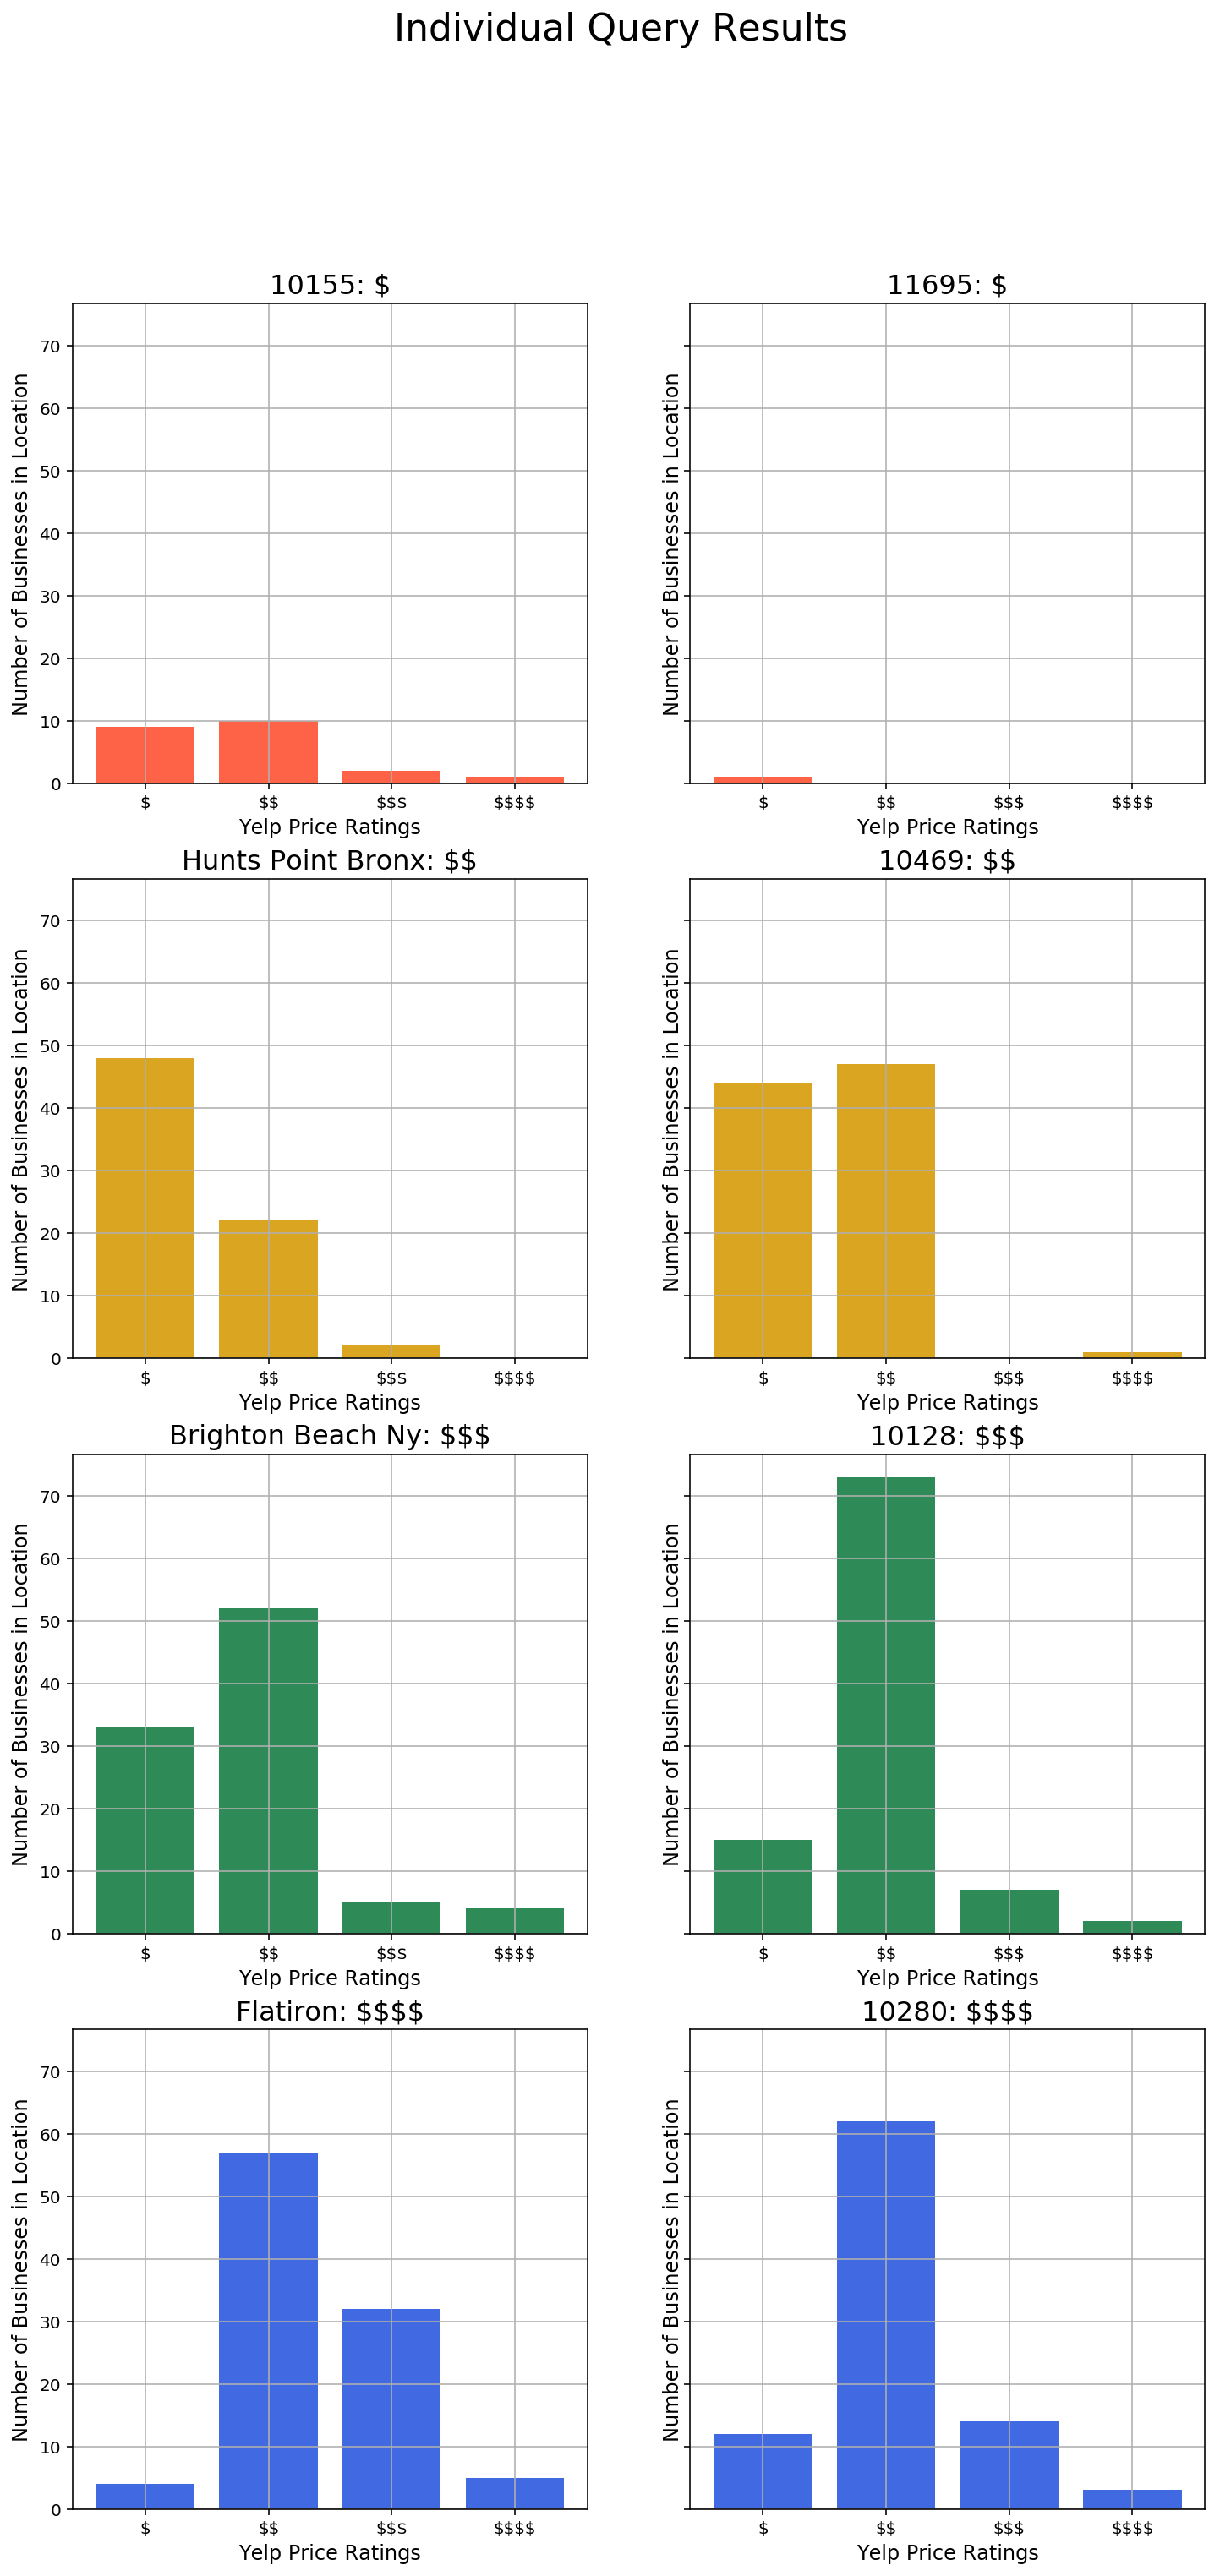

In [1102]:
yan.plot_query_results()

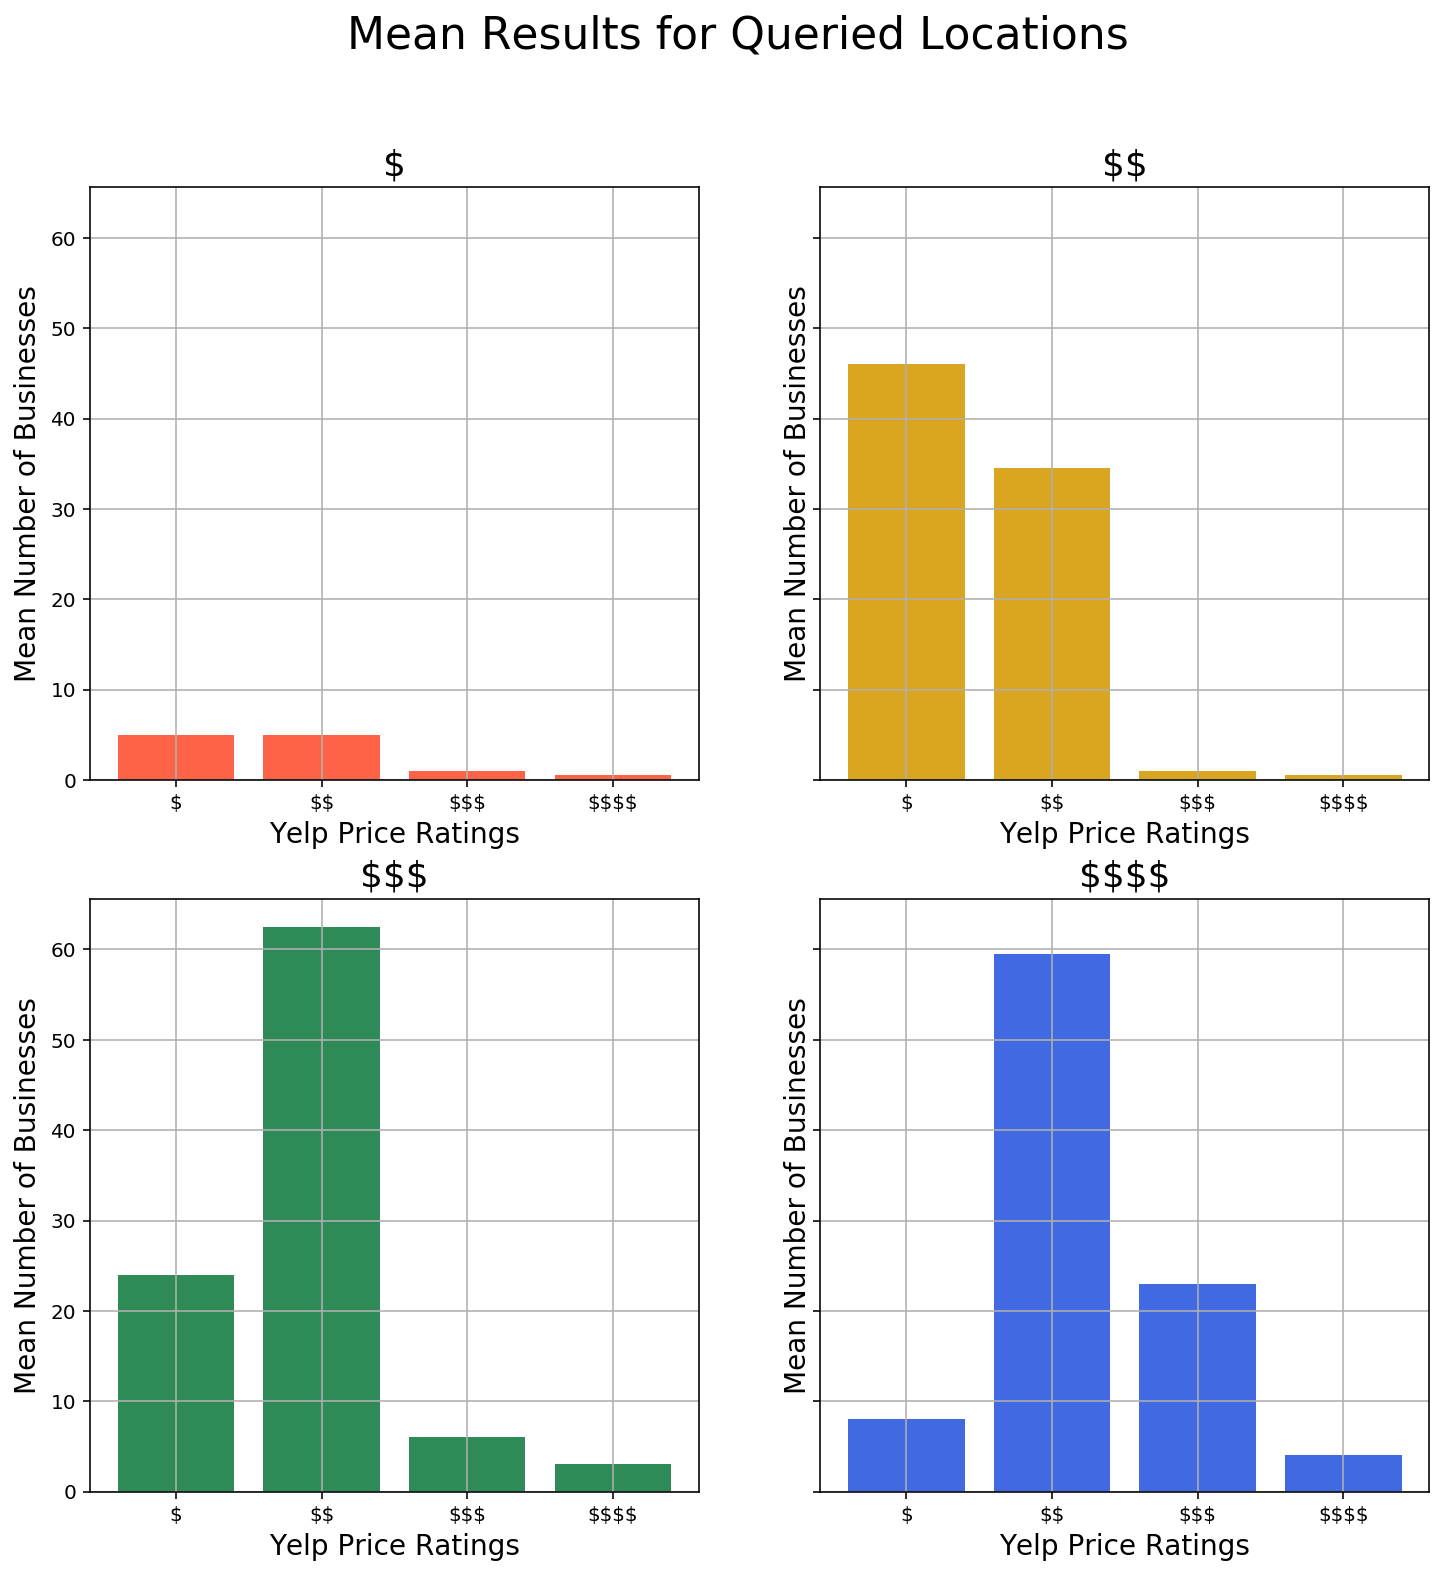

In [1103]:
yan.plot_query_results_mean()

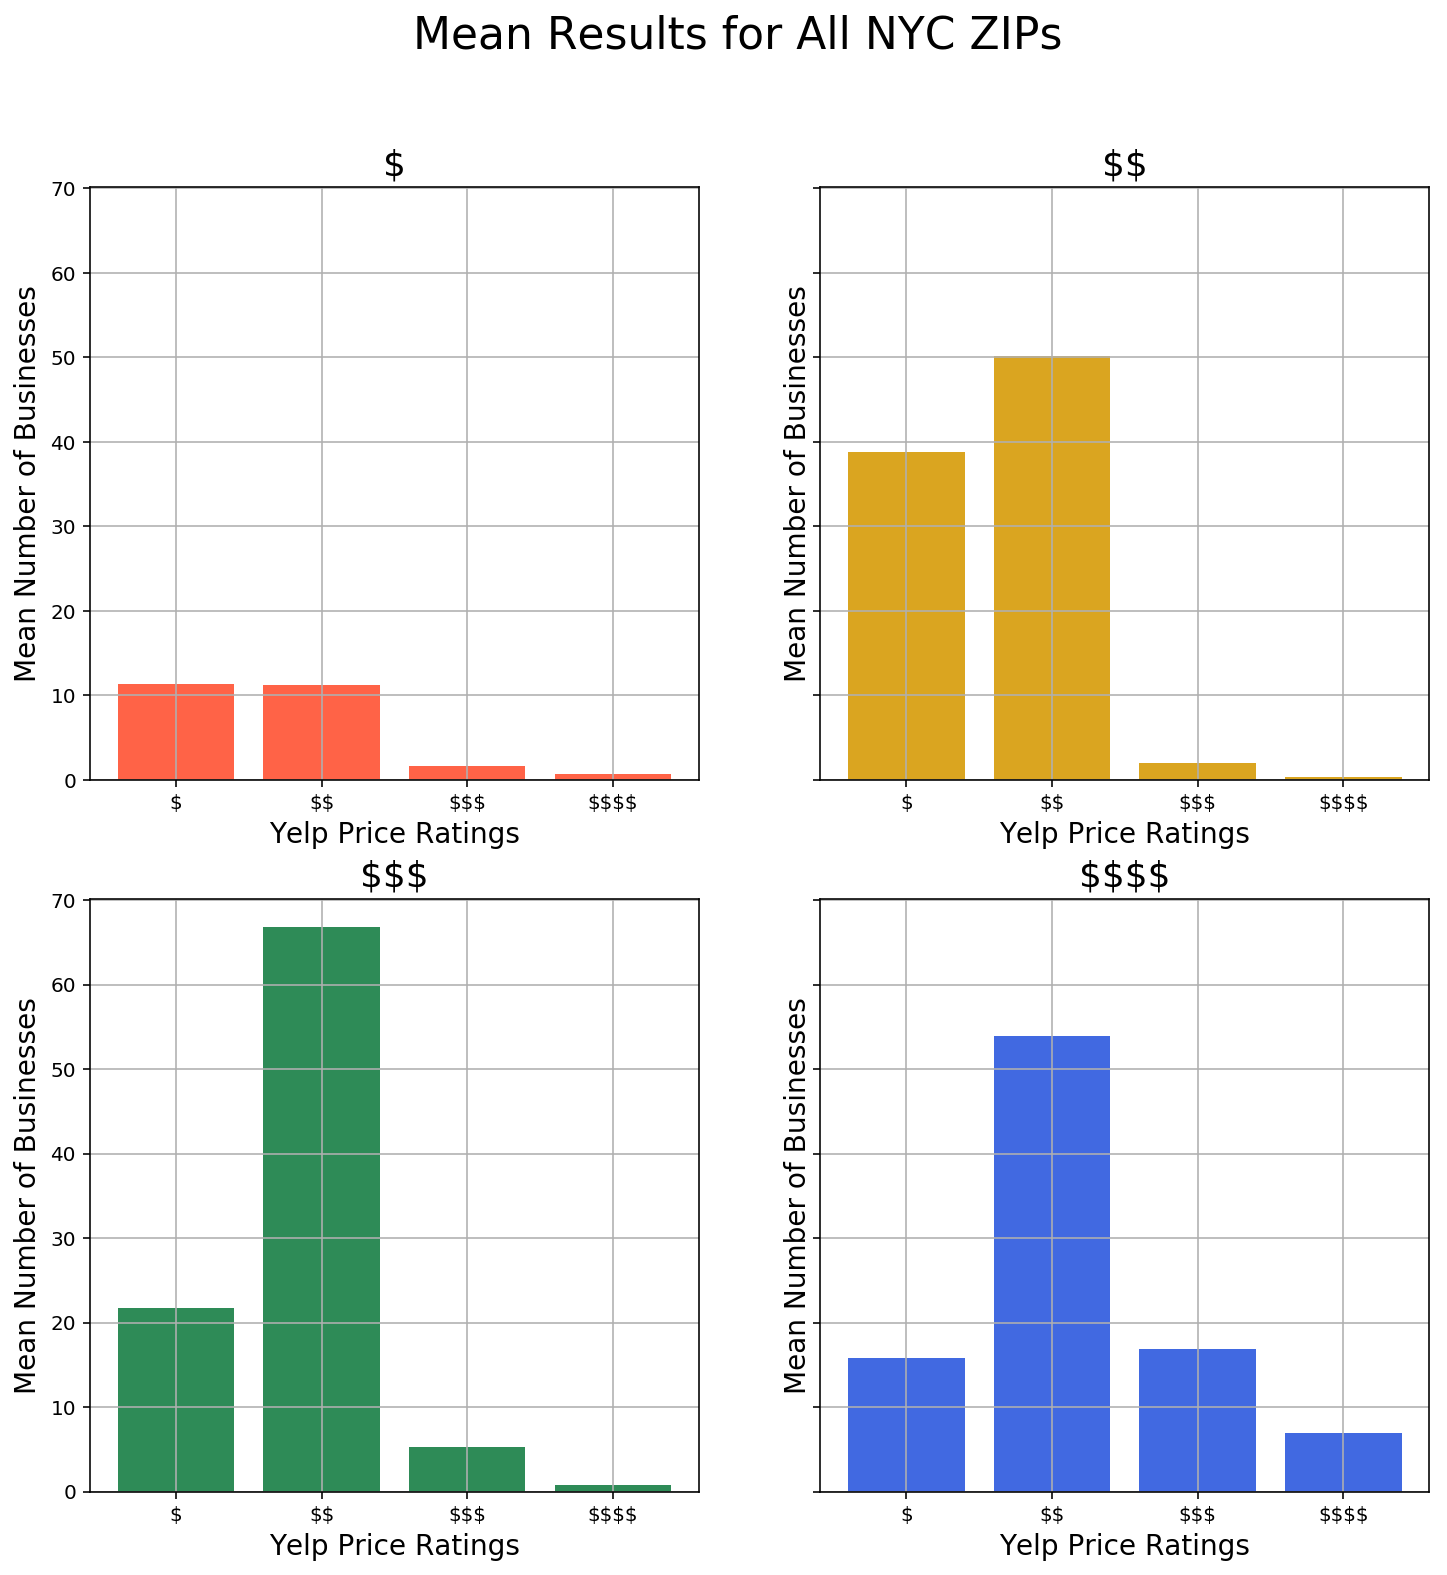

In [1104]:
yan.plot_model_results()

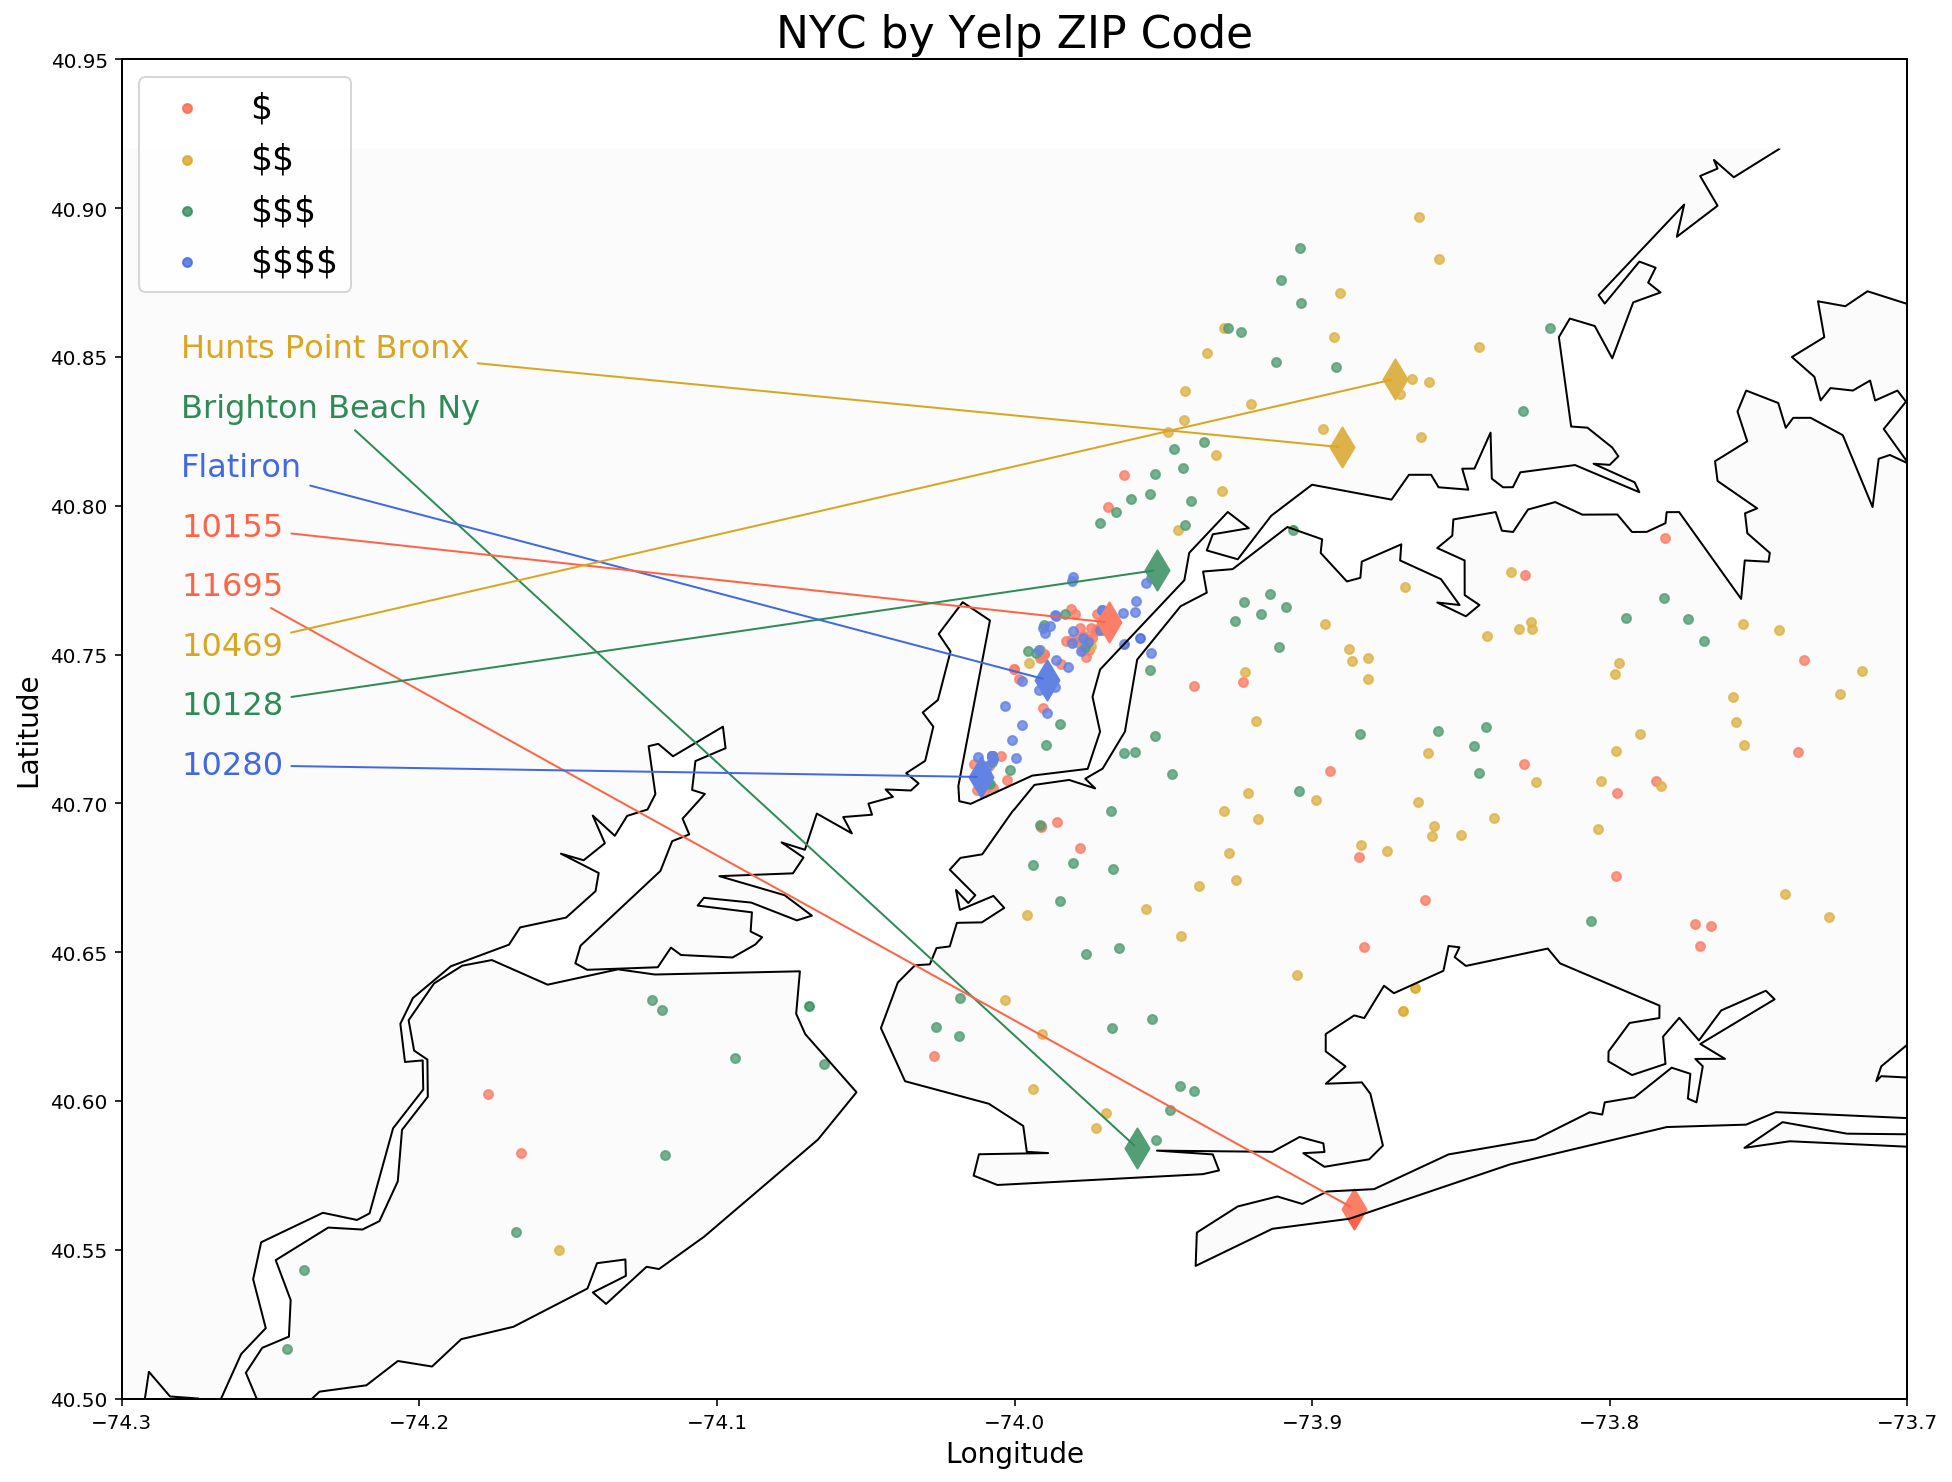

In [1105]:
yan.plot_nyc_map()

In [1092]:
yan.get_affluence(['SOHO','DUMBO','FIDI','Spanish Harlem','Astoria',])

SOHO
DUMBO
FIDI
Spanish Harlem
Astoria


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:219: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.


,location,city,state,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,pr_4,...,pr_4m,pr_totm,pr_1s,pr_2s,pr_3s,pr_4s,pr_totms,pred,pred_$,pred_num
0,DUMBO,Brooklyn,NY,18,3548,63,22268,8,3227,2,...,8,176,-0.399092,0.737721,0.429820,0.135171,0.627099,3,$\$\$,2
1,FIDI,New York,NY,23,22117,55,75210,11,10188,3,...,12,178,-0.004261,0.395340,0.901490,0.507226,0.659196,3,$\$\$,2
2,Spanish Harlem,New York,NY,17,17844,68,70884,4,5640,6,...,24,189,-0.478058,0.951710,-0.199074,1.623392,0.835728,3,$\$\$,2
3,Astoria,Astoria,NY,17,6246,75,43408,5,1933,0,...,0,182,-0.478058,1.251294,-0.041851,-0.608939,0.723390,3,$\$\$,2
4,SOHO,New York,NY,18,25936,54,83032,26,26349,2,...,8,212,-0.399092,0.352542,3.259843,0.135171,1.204841,1,$\$\$\$,3


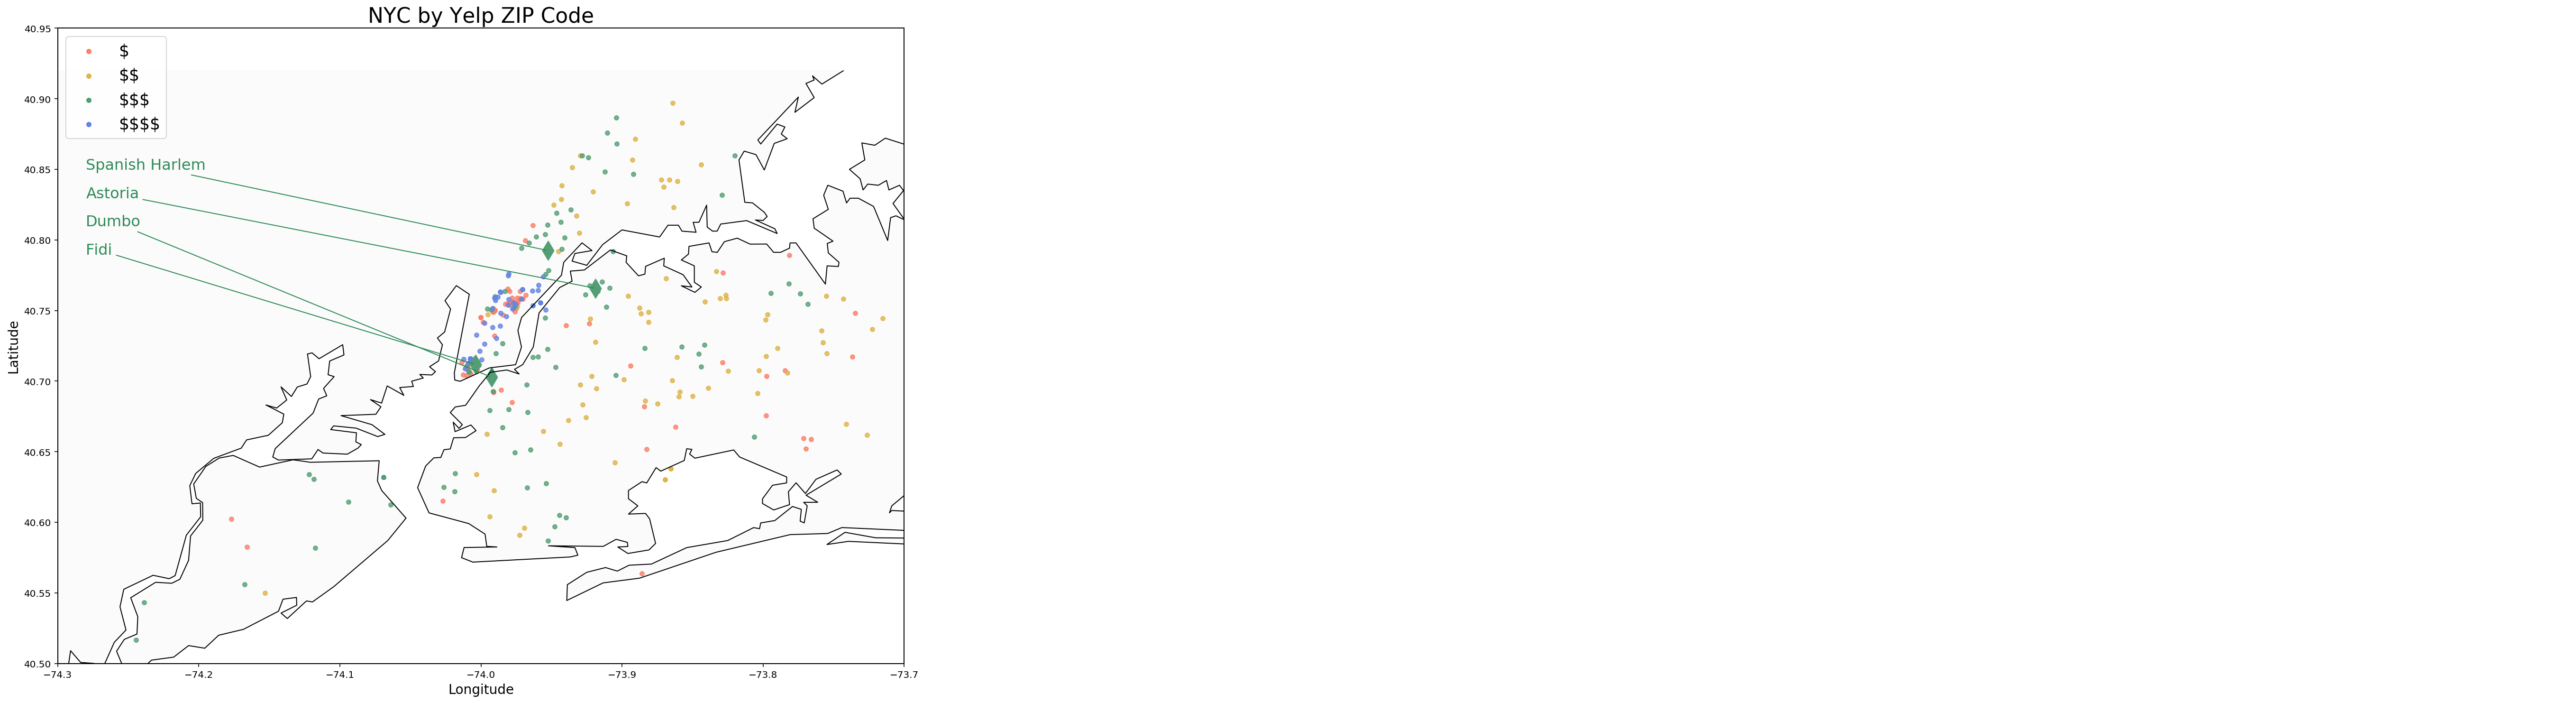

In [1094]:
yan.plot_nyc_map()

In [1095]:
yan.get_affluence(['SOHO','DUMBO','FIDI','Spanish Harlem'])

SOHO
DUMBO
FIDI
Spanish Harlem


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:219: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.


,location,city,state,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,pr_4,...,pr_4m,pr_totm,pr_1s,pr_2s,pr_3s,pr_4s,pr_totms,pred,pred_$,pred_num
0,DUMBO,Brooklyn,NY,18,3548,63,22268,8,3227,2,...,8,176,-0.399092,0.737721,0.429820,0.135171,0.627099,3,$\$\$,2
1,FIDI,New York,NY,23,22117,55,75210,11,10188,3,...,12,178,-0.004261,0.395340,0.901490,0.507226,0.659196,3,$\$\$,2
2,Spanish Harlem,New York,NY,17,17844,68,70884,4,5640,6,...,24,189,-0.478058,0.951710,-0.199074,1.623392,0.835728,3,$\$\$,2
3,SOHO,New York,NY,18,25936,54,83032,26,26349,2,...,8,212,-0.399092,0.352542,3.259843,0.135171,1.204841,1,$\$\$\$,3


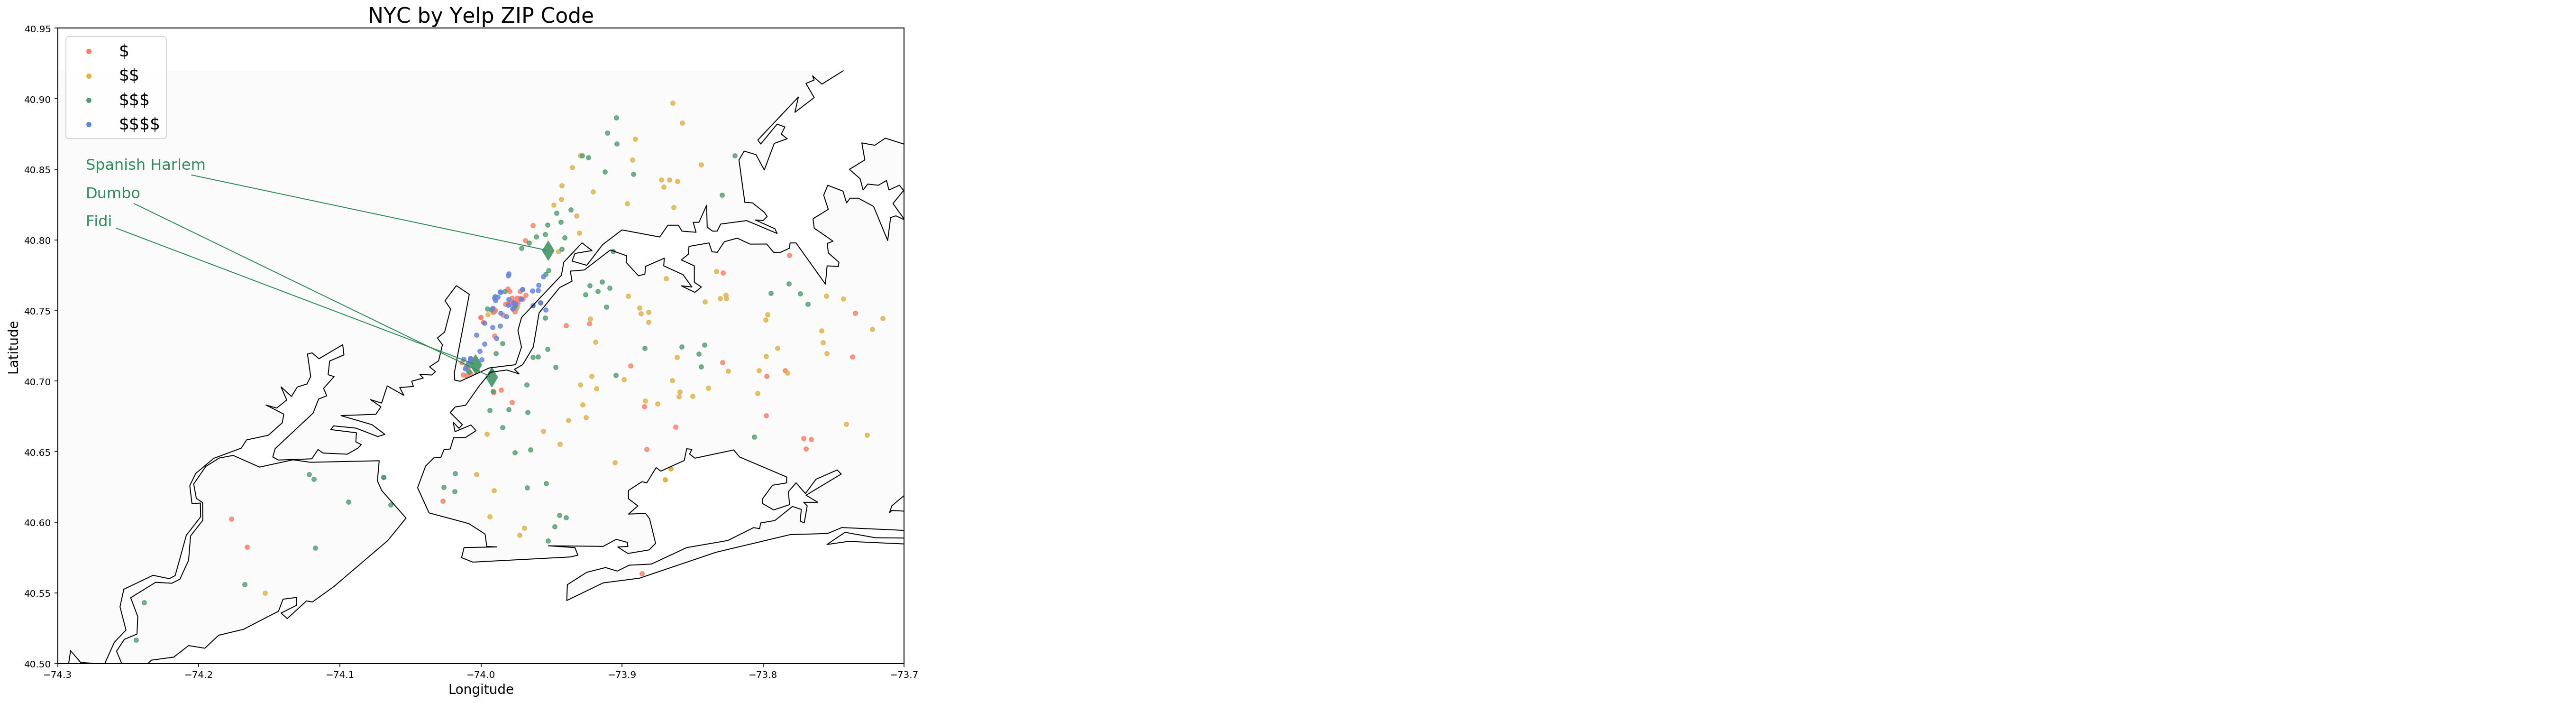

In [1096]:
yan.plot_nyc_map()

In [1062]:
yan.get_affluence(['SOHO','DUMBO','FIDI','Spanish Harlem','Astoria','Bushwick','Staten Island','Manhattan','hunts point bronx','botanical garden','10155'])

SOHO
DUMBO
FIDI
Spanish Harlem
Astoria
Bushwick
Staten Island
Manhattan
hunts point bronx
botanical garden
10155


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:218: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.


,location,city,state,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,pr_4,...,pr_4m,pr_totm,pr_1s,pr_2s,pr_3s,pr_4s,pr_totms,pred,pred_$,pred_num
0,10155,New York,NY,9,1137,10,2335,2,388,1,...,4,39,-1.109789,-1.530556,-0.513521,-0.236884,-1.571529,0,$,0
1,hunts point bronx,Bronx,NY,48,533,22,597,2,10,0,...,0,98,1.969896,-1.016984,-0.513521,-0.608939,-0.624675,2,$\$,1
2,DUMBO,Brooklyn,NY,18,3548,63,22267,8,3227,2,...,8,176,-0.399092,0.737721,0.429820,0.135171,0.627099,3,$\$\$,2
3,FIDI,New York,NY,23,22117,55,75209,11,10188,3,...,12,178,-0.004261,0.395340,0.901490,0.507226,0.659196,3,$\$\$,2
4,Spanish Harlem,New York,NY,17,17844,68,70883,4,5640,6,...,24,189,-0.478058,0.951710,-0.199074,1.623392,0.835728,3,$\$\$,2
5,Astoria,Astoria,NY,17,6246,75,43408,5,1933,0,...,0,182,-0.478058,1.251294,-0.041851,-0.608939,0.723390,3,$\$\$,2
6,Bushwick,Brooklyn,NY,27,6143,66,18620,3,2264,2,...,8,176,0.311604,0.866114,-0.356298,0.135171,0.627099,3,$\$\$,2
7,Staten Island,Staten Island,NY,15,1903,74,32978,9,1553,1,...,4,194,-0.635991,1.208496,0.587043,-0.236884,0.915970,3,$\$\$,2
8,botanical garden,Tulsa,OK,15,1132,66,10341,5,687,1,...,4,166,-0.635991,0.866114,-0.041851,-0.236884,0.466615,3,$\$\$,2
9,SOHO,New York,NY,18,25936,54,83032,26,26349,2,...,8,212,-0.399092,0.352542,3.259843,0.135171,1.204841,1,$\$\$\$,3


In [1063]:
yan.plot_nyc_map(16,16)

In [ ]:
yan.plot_model_results()

In [ ]:
yan.plot_query_results_mean()

In [ ]:
yan.plot_query_results()